# Circuit A classical fidelity

In [2]:
import numpy as np
from qiskit import *
from qiskit.visualization import *
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit import execute, BasicAer
from qiskit.compiler import transpile
from qiskit.quantum_info.operators import Operator, Pauli
from qiskit.quantum_info import process_fidelity
from qiskit.extensions import RXGate, XGate, CXGate
from qiskit.utils.mitigation import (complete_meas_cal,CompleteMeasFitter)
import qiskit_ibm_provider

In [36]:
def A_gate(theta, qubits, circ, phi=0, l=0, f=True):
    '''Adds the gate to the circuit circ'''
    a = qubits[0] # first qubit
    b = qubits[1] # second qubit
    
    if f:
        circ.cx(b,a) # adding the first CNOT, for which qubit b is the control and qubit a is the target
    else: 
        circ.x(a)
    # now comes the R dagger gate which has two parameters: theta and phi
    # but in our case phi is always zero
    ry1 = f'Y_{str(l)}^{-1}'
    ry  = f'Y_{str(l)}'
    rz = f'Z_{str(l)}'
    rz1 = f'Z_{str(l)}^{-1}'
    circ.ry(-(theta+np.pi/2),b, label=ry1) # rotation around the y axis
    circ.rz(-(phi+np.pi),b) # rotation around the z axis 
    
    # now the second CNOT for which target: b, control:a
    circ.cx(a,b)
    
    # and now the R gate for which we use the same two parameters
    circ.rz((phi+np.pi),b)
    circ.ry((theta+np.pi/2),b, label = ry)
    
    #and the last CNOT
    circ.cx(b,a)

In [20]:
def circ_maker(n, qubits, measure=False, f=True): 
    '''Creates the full quantum circuit'''
    
    theta1 = 3*np.pi/4
    theta2 = -2.97167
    theta3 = -2.18628 
    theta4 = np.pi
    theta5 = 5.23599
    
    a = qubits[0]
    b = qubits[1]
    c = qubits[2]
    d = qubits[3]

    qreg = QuantumRegister(n)
    creg = ClassicalRegister(4)
    circ = QuantumCircuit(qreg, creg)
    circ.x(b)
    circ.x(d)
    
    A_gate(theta=theta1, qubits=[a,b], circ=circ, l=1, f=f)
    A_gate(theta=theta2, qubits=[c,d], circ=circ, l=2, f=f)
    A_gate(theta=theta3, qubits=[b,c], circ=circ, l=3)
    A_gate(theta=theta4, qubits=[a,b], circ=circ, l=4)
    A_gate(theta=theta5, qubits=[c,d], circ=circ, l=5)
    A_gate(theta=theta3, qubits=[b,c], circ=circ, l=3)

    if measure:
        circ.measure([a,b,c,d], [0,1,2,3])
    else: 
        pass 
    
    return circ, qreg, creg

In [21]:
def class_fid(dict1, dict2=None, comp_to_Cab=False):
    '''Measures classical fidelity of measured state'''
    
    dict_perfect = {
    "0011" : 1/3,
    "1100" : 1/3,
    "0101" : 1/12,
    "0110" : 1/12,
    "1001" : 1/12,
    "1010" : 1/12
    }
    
    if comp_to_Cab == True: 
        dict2 = dict_perfect
    else: 
        pass
    fid = 0 
    len1 = 0
    len2 = 0
    for key in dict1: 
        len1 += dict1[key]
    for key in dict2: 
        len2 += dict2[key]
        
    for key in dict1: 
        if key in dict2: 
            fid += (dict1[key]* dict2[key]/(len1*len2))**0.5
        else: 
            pass
    return fid

In [22]:
def mitigation(backend, n, qubits, shots, direct_counts):
    '''Calculates mitigated shot numbers'''
   
    qr = QuantumRegister(n)
    meas_calibs, state_labels = complete_meas_cal(qubit_list=qubits, qr=qr, circlabel='mcal')
    cal_job = execute(meas_calibs, backend=backend, shots=shots)
    cal_results = cal_job.result()
    meas_fitter = CompleteMeasFitter(cal_results, state_labels, circlabel='mcal')
    meas_filter = meas_fitter.filter
    mitigated_counts = meas_filter.apply(direct_counts) 
    
    return mitigated_counts, meas_filter

In [23]:
def saver(filename, backend_name, time, shots, qubits, direct_counts, mitigated_counts, meas_filter):
    '''Saves data to file'''
    
    with open (filename+".txt", "w") as f: 
        f.write("Backend: "+backend_name+"\n")
        f.write("date: "+ str(time)+"\n")
        f.write("Qubits in use: "+str(qubits)+"\n")
        f.write("Shots: "+str(shots)+"\n")
        f.write("\n")
        f.write("Classical fidelities:"+"\n")
        f.write("\t"+"direct: "+str(class_fid(dict1=direct_counts, comp_to_Cab = True))+"\n")
        f.write("\t"+"mitigated:"+str(class_fid(dict1=mitigated_counts, comp_to_Cab=True))+"\n")
        f.write("Direct counts: "+"\n")
        for key in direct_counts:
            f.write(str(key)+": "+str(direct_counts[key])+"\n")

        f.write("Mitigated_counts: "+"\n")
        for key in mitigated_counts:
            f.write(str(key)+": "+str(mitigated_counts[key])+"\n")
                

        f.write("Readout error mitigation matrix:"+"\n")
        for line in meas_filter.cal_matrix:
            f.write(str(line)+"\n")

## Test

In [37]:
backend = Aer.get_backend('qasm_simulator')
backend_name = 'Aer qasm_simulator'
time = "2021.04.23"
n = 5
shots = 8192
qubits = np.array([0,1,2,3])

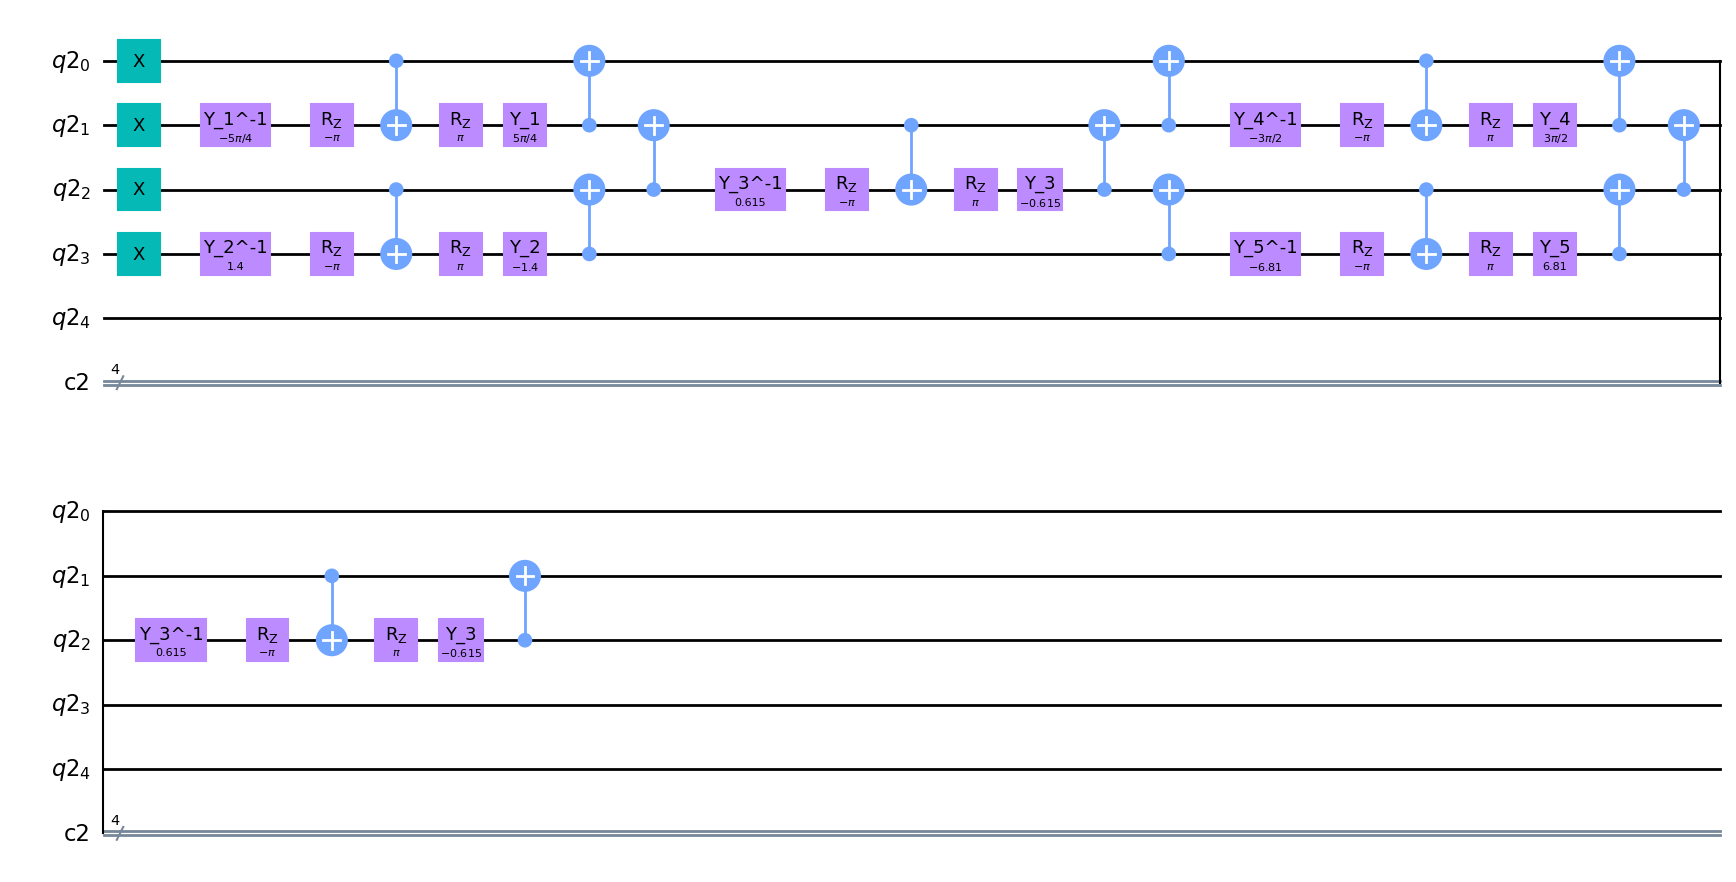

In [38]:
circ,qreg,creg = circ_maker(n=n, qubits=qubits, f=False)

circ.draw()

In [ ]:
circ.measure(qubits,[0,1,2,3]) # append the measurement operations to the circuit

In [43]:
job = execute(circ, backend=backend, shots=shots, optimization_level=0)
direct_counts = job.result().get_counts()

mitigated_counts, meas_filter  = mitigation(backend=backend, n=n, qubits=qubits, shots = shots,
                                       direct_counts=direct_counts)

In [44]:
class_fid(direct_counts, comp_to_Cab=True)

0.9999365761428909

In [46]:
saver(filename="Test", time=time, backend_name=backend_name, shots=shots, qubits = qubits,
     direct_counts=direct_counts, mitigated_counts=mitigated_counts, meas_filter=meas_filter)

## Main runs

In [ ]:
# change relevant data manually for each run
backend = provider.get_backend('ibmq_casablanca')
backend_name = 'Casablanca'

time = "2021.04.26"
n = 7
shots = 8192

filename = "Casablanca0"
qubits = np.array([0,1,3,5])

In [ ]:
circ, qreg, creg = circ_maker(n=n, qubits=qubits, f=False)
initial_layout = {
    qreg[0]: 0,
    qreg[1]: 1,
    qreg[2]: 2,
    qreg[3]: 3,
    qreg[4]: 4,
    qreg[5]: 5,
    qreg[6]: 6,   
}

tr_circ = transpile(circ ,backend=backend, optimization_level=3, initial_layout=initial_layout)

tr_circ.draw()

In [ ]:
tr_circ.measure(qubits,[0,1,2,3])

In [ ]:
job = execute(tr_circ, backend=backend, shots=shots, optimization_level=0)
direct_counts = job.result().get_counts()

mitigated_counts, meas_filter = mitigation(backend=backend, n=n, qubits=qubits, 
                                            shots=shots, direct_counts=direct_counts)

In [ ]:
class_fid(direct_counts, comp_to_Cab=True)

In [ ]:
class_fid(mitigated_counts, comp_to_Cab=True)

In [ ]:
saver(filename=filename, time=time,backend_name=backend_name, shots=shots, qubits=qubits,
     direct_counts=direct_counts, mitigated_counts=mitigated_counts, meas_filter=meas_filter)